<a href="https://colab.research.google.com/github/maksim267/Credit_Scoring/blob/main/%D0%9A%D1%80%D0%B5%D0%B4%D0%B8%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BA%D0%BE%D1%80%D0%B8%D0%BD%D0%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кредитный скоринг

# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !unzip -q /content/gdrive/MyDrive/findata-creditscoring.zip

In [3]:
data = pd.read_csv('./credit_train.csv')
target_col="Loan Status"

In [4]:
data

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6,1,228190,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35,0,229976,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18,1,297996,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9,0,256329,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15,0,253460,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3f94c18c-ba8f-45d0-8610-88a684a410a9,2da51983-cfef-4b8f-a733-5dfaf69e9281,Fully Paid,147070,Short Term,725.0,475437.0,7 years,Own Home,other,2202.86,22.3,NaN,5,0,47766,658548.0,0.0,0.0
99996,06eba04f-58fc-424a-b666-ed72aa008900,77f2252a-b7d1-4b07-a746-1202a8304290,Fully Paid,99999999,Short Term,732.0,1289416.0,1 year,Rent,Debt Consolidation,13109.05,9.4,21.0,22,0,153045,509234.0,0.0,0.0
99997,e1cb4050-eff5-4bdb-a1b0-aabd3f7eaac7,2ced5f10-bd60-4a11-9134-cadce4e7b0a3,Fully Paid,103136,Short Term,742.0,1150545.0,6 years,Rent,Debt Consolidation,7315.57,18.8,18.0,12,1,109554,537548.0,1.0,0.0
99998,81ab928b-d1a5-4523-9a3c-271ebb01b4fb,3e45ffda-99fd-4cfc-b8b8-446f4a505f36,Fully Paid,530332,Short Term,746.0,1717524.0,9 years,Rent,Debt Consolidation,9890.07,15.0,NaN,8,0,404225,738254.0,0.0,0.0


# Работа над пропущенными значениями

In [5]:
data["Customer ID"].value_counts()# pfvtnbv

,count
Customer ID,
56a0ba34-abcd-413a-8c82-0fc0404bec6f,2
9baf6d5d-f744-4332-abb0-e939b75cde40,2
cbe53e22-ba67-4eaf-a4fb-c5acdd12ec66,2
54f57722-2473-4dd8-b69b-82b5b0c1c9f9,2
967e8733-7189-49b7-a3ab-6a1d0e1abdac,2
...,...
8583fc23-bf8d-434b-b33d-1c8152e3e254,1
f423f0f1-ee1c-4cca-ab91-b8c349b24fcf,1
4ec8ccaf-9aeb-45b7-aa58-b46f9c3dac2e,1


In [6]:
data.loc[data["Customer ID"].map(data["Customer ID"].value_counts()) > 1, "Number of Occurrences"] = 1
data.loc[data["Customer ID"].map(data["Customer ID"].value_counts()) == 1, "Number of Occurrences"] = 0
data = data.drop(columns=["Customer ID","Loan ID"])

In [7]:
data.isna().sum(axis=0)

,0
Loan Status,0
Current Loan Amount,0
Term,0
Credit Score,19154
Annual Income,19154
Years in current job,4222
Home Ownership,0
Purpose,0
Monthly Debt,0
Years of Credit History,0


In [8]:
data["Credit Score"].value_counts().sort_index()

,count
Credit Score,
585.0,12
586.0,7
587.0,11
588.0,20
589.0,6
...,...
7470.0,51
7480.0,43
7490.0,23


In [9]:
data[["Annual Income","Credit Score"]].sort_values(by="Annual Income", ascending=True)

,Annual Income,Credit Score
66089,76627.0,736.0
50646,81092.0,662.0
66656,94867.0,737.0
13090,97033.0,738.0
99552,106533.0,745.0
...,...,...
99978,NaN,NaN
99982,NaN,NaN
99988,NaN,NaN
99989,NaN,NaN


In [10]:
data["Annual Income"] =data["Annual Income"].fillna(data['Annual Income'].median())
data["Credit Score"]=data["Credit Score"].fillna(data['Credit Score'].median())

In [11]:
data["Years in current job"].value_counts()

,count
Years in current job,
10+ years,31121
2 years,9134
3 years,8169
< 1 year,8164
5 years,6787
1 year,6460
4 years,6143
6 years,5686
7 years,5577


In [12]:
data["Years in current job"]=data["Years in current job"].fillna(-1)

In [13]:
data["Months since last delinquent"].value_counts().sort_index()

,count
Months since last delinquent,
0.0,216
1.0,289
2.0,418
3.0,445
4.0,513
...,...
141.0,1
143.0,1
148.0,1


In [14]:
# data = data.drop(columns=["Months since last delinquent"])
data["Months since last delinquent"]=data["Months since last delinquent"].fillna(-1)

In [15]:
data = data.drop(index=data[pd.isna(data["Maximum Open Credit"])].index).reset_index(drop=True)

In [16]:
data["Bankruptcies"].value_counts().sort_index()

,count
Bankruptcies,
0.0,88772
1.0,10475
2.0,417
3.0,93
4.0,27
5.0,7
6.0,2
7.0,1


In [17]:
# data = data.drop(columns=["Bankruptcies"])
data["Bankruptcies"]=data["Bankruptcies"].fillna(0)

In [18]:
data = data.drop(index=data[pd.isna(data["Tax Liens"])].index).reset_index(drop=True)

In [19]:
data.isna().sum()

,0
Loan Status,0
Current Loan Amount,0
Term,0
Credit Score,0
Annual Income,0
Years in current job,0
Home Ownership,0
Purpose,0
Monthly Debt,0
Years of Credit History,0


# Ручное преобразование некоторых категориальных признаков OneHotEncoding над остальными

In [20]:
data.dtypes

,0
Loan Status,object
Current Loan Amount,int64
Term,object
Credit Score,float64
Annual Income,float64
Years in current job,object
Home Ownership,object
Purpose,object
Monthly Debt,float64
Years of Credit History,float64


In [21]:
old_real_columns=list(data.columns[data.dtypes=='int64'])+list(data.columns[data.dtypes=='float64'])

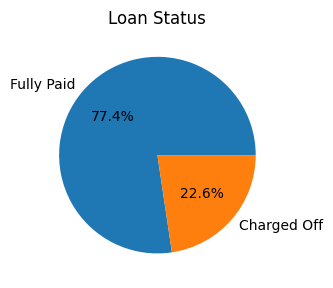

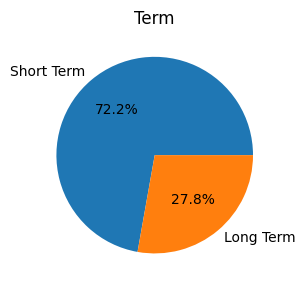

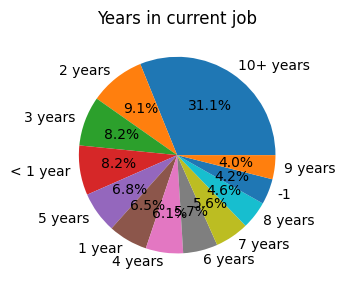

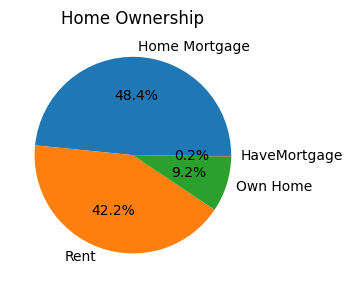

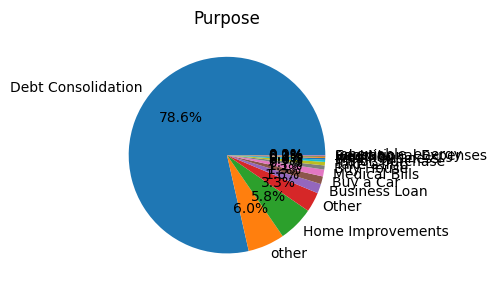

In [22]:

k=0
# посмотрим на то какие значения принимают категориальные признаки
for col in data.columns[data.dtypes=='object']:
  k+=1
  plt.figure(figsize=(30,30))
  val = data[col].value_counts()
  plt.subplot(8, 2, k)
  plt.pie(val.values, labels=val.index, autopct='%1.1f%%')
  plt.title(col)

In [23]:
data.loc[data['Loan Status']=='Fully Paid', 'Loan Status']=1
data.loc[data['Loan Status']=='Charged Off', 'Loan Status']=0
data["Loan Status"]=data['Loan Status'].astype(int)


data.loc[data['Term']=='Long Term', 'Term']=1
data.loc[data['Term']=='Short Term', 'Term']=0
data["Term"]=data['Term'].astype(int)

conversion_dict = {
    "8 years": 8,
    "10+ years": 10,
    "3 years": 3,
    "5 years": 5,
    "7 years": 7,
    -1: -1,
    "1 year": 1,
    "2 years": 2,
    "4 years": 4,
    "6 years": 6,
    "9 years": 9,
    "< 1 year": 0
}
data["Years in current job"] = data["Years in current job"].map(conversion_dict)
data["Years in current job"]=data['Years in current job'].astype(int)

In [24]:
data

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Number of Occurrences
0,1,445412,0,709.0,1167493.0,8,Home Mortgage,Home Improvements,5214.74,17.2,-1.0,6,1,228190,416746.0,1.0,0.0,1.0
1,1,262328,0,724.0,1174162.0,10,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35,0,229976,850784.0,0.0,0.0,0.0
2,1,99999999,0,741.0,2231892.0,8,Own Home,Debt Consolidation,29200.53,14.9,29.0,18,1,297996,750090.0,0.0,0.0,0.0
3,1,347666,1,721.0,806949.0,3,Own Home,Debt Consolidation,8741.90,12.0,-1.0,9,0,256329,386958.0,0.0,0.0,1.0
4,1,176220,0,724.0,1174162.0,5,Rent,Debt Consolidation,20639.70,6.1,-1.0,15,0,253460,427174.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99983,1,147070,0,725.0,475437.0,7,Own Home,other,2202.86,22.3,-1.0,5,0,47766,658548.0,0.0,0.0,1.0
99984,1,99999999,0,732.0,1289416.0,1,Rent,Debt Consolidation,13109.05,9.4,21.0,22,0,153045,509234.0,0.0,0.0,0.0
99985,1,103136,0,742.0,1150545.0,6,Rent,Debt Consolidation,7315.57,18.8,18.0,12,1,109554,537548.0,1.0,0.0,0.0
99986,1,530332,0,746.0,1717524.0,9,Rent,Debt Consolidation,9890.07,15.0,-1.0,8,0,404225,738254.0,0.0,0.0,0.0


In [25]:
data["Purpose"].value_counts()

,count
Purpose,
Debt Consolidation,78543
other,6036
Home Improvements,5838
Other,3250
Business Loan,1569
Buy a Car,1265
Medical Bills,1127
Buy House,678
Take a Trip,573


In [26]:
data["Purpose"] = data["Purpose"].str.lower()

In [27]:
data.dtypes

,0
Loan Status,int64
Current Loan Amount,int64
Term,int64
Credit Score,float64
Annual Income,float64
Years in current job,int64
Home Ownership,object
Purpose,object
Monthly Debt,float64
Years of Credit History,float64


In [28]:
data

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Number of Occurrences
0,1,445412,0,709.0,1167493.0,8,Home Mortgage,home improvements,5214.74,17.2,-1.0,6,1,228190,416746.0,1.0,0.0,1.0
1,1,262328,0,724.0,1174162.0,10,Home Mortgage,debt consolidation,33295.98,21.1,8.0,35,0,229976,850784.0,0.0,0.0,0.0
2,1,99999999,0,741.0,2231892.0,8,Own Home,debt consolidation,29200.53,14.9,29.0,18,1,297996,750090.0,0.0,0.0,0.0
3,1,347666,1,721.0,806949.0,3,Own Home,debt consolidation,8741.90,12.0,-1.0,9,0,256329,386958.0,0.0,0.0,1.0
4,1,176220,0,724.0,1174162.0,5,Rent,debt consolidation,20639.70,6.1,-1.0,15,0,253460,427174.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99983,1,147070,0,725.0,475437.0,7,Own Home,other,2202.86,22.3,-1.0,5,0,47766,658548.0,0.0,0.0,1.0
99984,1,99999999,0,732.0,1289416.0,1,Rent,debt consolidation,13109.05,9.4,21.0,22,0,153045,509234.0,0.0,0.0,0.0
99985,1,103136,0,742.0,1150545.0,6,Rent,debt consolidation,7315.57,18.8,18.0,12,1,109554,537548.0,1.0,0.0,0.0
99986,1,530332,0,746.0,1717524.0,9,Rent,debt consolidation,9890.07,15.0,-1.0,8,0,404225,738254.0,0.0,0.0,0.0


In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

real_columns = np.hstack([np.array(data.columns[data.dtypes=='int64']),np.array(data.columns[data.dtypes=='float64']) ])# выделение вещественных признаков
real_columns=real_columns[real_columns!='Loan Status']
real_data = data[real_columns]
transformSS = StandardScaler().fit(real_data)
real_dataSS=transformSS.transform(real_data)
# real_dataSS=real_data

cat_columns=data.columns[data.dtypes=='object']# выделение категориальных признаков
cat_data = data[cat_columns]

encoder = OneHotEncoder(sparse_output=False)
one_hot_data = encoder.fit(cat_data)
one_hot_data = pd.DataFrame(one_hot_data.transform(cat_data), index=cat_data.index, columns=encoder.get_feature_names_out())
new_data = pd.concat([pd.DataFrame(real_dataSS, columns=real_columns), one_hot_data,data[target_col]], axis='columns')

# Анализ данных и работа над выбрасами

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
new_data[real_columns]

,Current Loan Amount,Term,Years in current job,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Maximum Open Credit,Bankruptcies,Tax Liens,Number of Occurrences
0,-0.356008,-0.620445,0.628845,-1.023687,1.722944,-0.176618,-0.224867,-0.175986,-1.089016,-0.142371,-0.718851,-0.040916,2.513329,-0.113537,1.333266
1,-0.361768,-0.620445,1.153204,4.764859,-0.348675,-0.171870,-0.213620,-0.169150,1.217479,0.413546,-0.334272,0.011113,-0.334681,-0.113537,-0.750038
2,2.776193,-0.620445,0.628845,1.371573,1.722944,0.008960,-0.200874,0.914973,0.881093,-0.470220,0.563078,-0.000958,-0.334681,-0.113537,-0.750038
3,-0.359083,1.611746,-0.682053,-0.424872,-0.348675,-0.101811,-0.215869,-0.545527,-0.799308,-0.883594,-0.718851,-0.044487,-0.334681,-0.113537,1.333266
4,-0.364477,-0.620445,-0.157694,0.772758,-0.348675,-0.109438,-0.213620,-0.169150,0.177936,-1.724597,-0.718851,-0.039666,-0.334681,-0.113537,1.333266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99983,-0.365394,-0.620445,0.366666,-1.223293,-0.348675,-0.656271,-0.212870,-0.885311,-1.336401,0.584597,-0.718851,-0.011931,-0.334681,-0.113537,1.333266
99984,2.776193,-0.620445,-1.206412,2.169993,-0.348675,-0.376389,-0.207622,-0.051021,-0.440605,-1.254206,0.221230,-0.029829,-0.334681,-0.113537,-0.750038
99985,-0.366777,-0.620445,0.104486,0.173943,1.722944,-0.492009,-0.200125,-0.193357,-0.916461,0.085697,0.093037,-0.026435,2.513329,-0.113537,-0.750038
99986,-0.353336,-0.620445,0.891025,-0.624477,-0.348675,0.291368,-0.197126,0.387770,-0.705001,-0.455966,-0.718851,-0.002376,-0.334681,-0.113537,-0.750038


In [ ]:
plt.figure(figsize=(40,15))
sns.boxplot(data=new_data[old_real_columns])
plt.show()

In [ ]:
max(new_data["Maximum Open Credit"])

In [ ]:
  new_data['Maximum Open Credit'].mean()

In [ ]:
new_data.loc[new_data["Maximum Open Credit"]<=new_data['Maximum Open Credit'].mean()*10]

In [ ]:
new_data = new_data.drop(index=new_data[new_data["Maximum Open Credit"]>new_data['Maximum Open Credit'].mean()*10].index)

In [ ]:
new_data

In [ ]:
plt.figure(figsize=(40,15))
sns.boxplot(data=new_data[old_real_columns])
plt.show()

In [ ]:
max(new_data["Annual Income"])

In [ ]:
sns.histplot(data=new_data, x="Annual Income", bins=100, color='blue')  # Добавляем KDE (плавную линию)
plt.xlabel("Диапазоны значений")
plt.ylabel("Количество значений")
plt.show()

In [ ]:
new_data["Annual Income"].mean()

In [ ]:
# new_data.loc[new_data["Annual Income"]>=new_data["Annual Income"].mean()*10]

In [ ]:
# new_data = new_data.drop(index=new_data[new_data["Annual Income"]>new_data["Annual Income"].mean()*5].index)

In [ ]:
plt.figure(figsize=(40,15))
sns.boxplot(data=new_data[old_real_columns])
plt.show()

In [ ]:
new_data

In [ ]:
new_data = new_data.drop(index=new_data[(new_data["Current Loan Amount"]==max(new_data["Current Loan Amount"]))].index)
new_data = new_data.drop(index=new_data[(new_data["Current Credit Balance"]==new_data["Current Credit Balance"].mean()*5)].index)

In [ ]:
new_data

In [ ]:
plt.figure(figsize=(40,15))
sns.boxplot(new_data[old_real_columns])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Перебор всех признаков в real_columns
for column in old_real_columns:
    plt.figure(figsize=(12, 6))  # Размер графика для каждого признака
    sns.boxplot(data=new_data, x=column)
    plt.title(f"Boxplot for {column}", fontsize=16)  # Заголовок для графика
    plt.xlabel(column, fontsize=14)  # Подпись для оси X
    plt.ylabel("Values", fontsize=14)  # Подпись для оси Y
    plt.grid(True)
    plt.show()  # Отображение графика



# Проверка кореляции между признаками

In [ ]:
y=new_data[target_col]
new_data=new_data.drop(target_col, axis=1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the initial correlation matrix including the target
corrmat = pd.concat([new_data, y], axis=1).corr()

# Select top k columns based on correlation with the target
k = 10
cols = corrmat.nlargest(k, target_col)[target_col].index

# Subset the correlation matrix for these columns
cm = corrmat.loc[cols, cols].values

# Plot the heatmap
sns.set(font_scale=1.25)
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()

# Обучение модели

In [ ]:
new_data

In [ ]:
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_data, y, test_size=0.2, random_state=42)

В качестве примера, импортируем модель `LogisticRegression`

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%capture
!pip install catboost
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(),
    "AdaBoost": AdaBoostClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GaussianProcess": GaussianProcessClassifier(),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False)
}

trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name} обучен.")
